In [21]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch.optim import lr_scheduler

from recycle_cnn import CNN
from recycle_pretrained_cnn import PretrainCNN
from recycle_resnet import ResNet, BasicBlock
from collections import Counter

from tqdm import tqdm


In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(777)
if device=='cuda':
    torch.cuda.manual_seed_all(777)
    
learning_rate = 0.00001
num_epochs = 25
batch_size = 32
input_size = 256

In [23]:
trans = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
])
orig_train_set = torchvision.datasets.ImageFolder('data/train',transform=trans)
classes = orig_train_set.classes

aug_trans1 = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor(),
])
aug_trans2 = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomVerticalFlip(p=1),
    transforms.ToTensor(),
])
aug_train_set1 = torchvision.datasets.ImageFolder('data/train', transform=aug_trans1)
aug_train_set2 = torchvision.datasets.ImageFolder('data/train', transform=aug_trans2)

train_set = torch.utils.data.ConcatDataset([orig_train_set, aug_train_set1, aug_train_set2])


In [24]:
train_size = int(0.8 * len(train_set))
valid_size = len(train_set) - train_size
train_set, valid_set = torch.utils.data.random_split(train_set, [train_size, valid_size])

In [25]:
train_len = len(train_set)
class_weights = [0] * len(classes)
sample_weights = [0] * train_len

for idx, (data, label) in tqdm(enumerate(train_set), total=train_len):
    class_weights[label]+=1
for i in tqdm(range(len(classes))):
    class_weights[i] = (train_len-class_weights[i])/train_len
for idx, (data, label) in tqdm(enumerate(train_set), total=train_len):
    sample_weights[idx] = class_weights[label]
    
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
train_loader = DataLoader(train_set, batch_size=batch_size, sampler=sampler)
valid_loader = DataLoader(valid_set)


100%|██████████| 5030/5030 [00:25<00:00, 193.80it/s]


In [26]:
# model = CNN().to(device)
# model = ResNet(BasicBlock, [2, 2, 2, 2]).to(device)
model = PretrainCNN.to(device)

print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [27]:
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)
# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
total_batch = len(train_loader)

In [28]:
def train_one_epoch(data_loader):
    model.train()
    running_loss = 0
    total = 0
    correct = 0
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        preds = torch.max(outputs, 1)[1]
        correct += (preds == labels).sum()
        total += len(labels)
        running_loss += loss.detach()
        
    loss = (running_loss / len(data_loader)).item()
    accuracy = (correct * 100 / total).item()
    return loss, accuracy


In [29]:
best_valid_acc = 0

def eval_one_epoch(data_loader):
    global best_valid_acc
    
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    model.eval()
    running_loss = 0
    with torch.no_grad():
        total = 0
        correct = 0
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            preds = torch.max(outputs, 1)[1]
            correct += (preds == labels).sum()
            
            for label, prediction in zip(labels, preds):
                if label == prediction:
                    correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

            total += len(labels)
            running_loss += loss.detach()
        
        loss = (running_loss / len(data_loader)).item()
        accuracy = (correct * 100 / total).item()
        if accuracy > best_valid_acc:
            torch.save(model, 'best_model.pt')
        return loss, accuracy, correct_pred, total_pred

In [31]:
train_loss_hist = []
train_acc_hist = []
valid_loss_hist = []
valid_acc_hist = [] 
valid_class_acc_hist = {classname: [] for classname in classes}

pbar = tqdm(range(num_epochs))
for epoch in pbar:
    train_loss, train_acc = train_one_epoch(train_loader)
    exp_lr_scheduler.step() # learning rate를 step마다 조절해준다.
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)

    valid_loss, valid_acc, correct_pred, total_pred = eval_one_epoch(valid_loader)
    valid_loss_hist.append(valid_loss)
    valid_acc_hist.append(valid_acc)
    # print(f"Epoch: {epoch}\nTrain Loss: {train_loss_hist[-1]}, accuracy: {train_acc_hist[-1]}\n"+
    #     f"Valid loss: {valid_loss_hist[-1]}, accuracy: {valid_acc_hist[-1]}")
    
    # for classname, correct_count in correct_pred.items():
    #     accuracy = 100 * float(correct_count) / total_pred[classname]
    #     valid_class_acc_hist[classname].append(accuracy)
    #     print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
    pbar.set_description(f"epoch {epoch+1} ==> train acc: {train_acc}, valid acc: {valid_acc}")


epoch 1 ==> train acc: 97.93240356445312, valid acc: 93.48171997070312:   8%|▊         | 2/25 [01:26<16:35, 43.30s/it]


KeyboardInterrupt: 

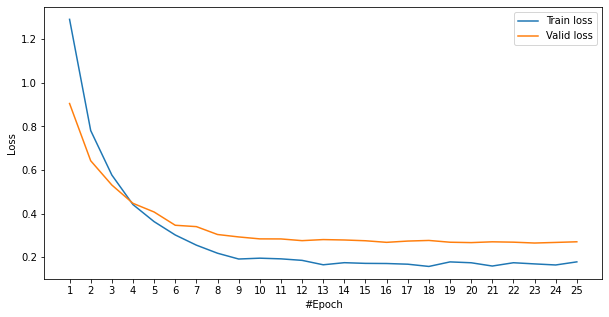

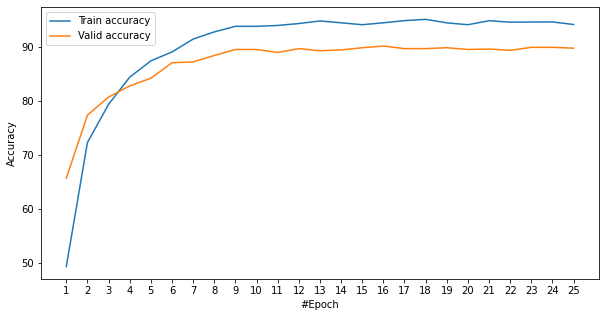

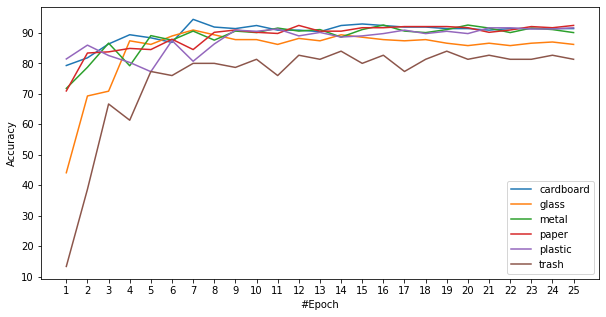

In [ ]:
epochs = list(range(1, num_epochs + 1))
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss_hist, label='Train loss')
plt.plot(epochs, valid_loss_hist, label='Valid loss')
plt.xlabel("#Epoch")
plt.ylabel("Loss")
plt.xticks(epochs)
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc_hist, label='Train accuracy')
plt.plot(epochs, valid_acc_hist, label='Valid accuracy')
plt.xlabel("#Epoch")
plt.ylabel("Accuracy")
plt.xticks(epochs)
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
for classname, accuracy in valid_class_acc_hist.items():
    plt.plot(epochs, accuracy, label='%s' % classname)
plt.xlabel("#Epoch")
plt.ylabel("Accuracy")
plt.xticks(epochs)
plt.legend()
plt.show()


In [ ]:
torch.save(model, 'model.pt')